## Week 7: The decision tree classfier; and two concepts: impurity(entropy) and information gain

Instructor: Cornelia Paulik <br>
Email: cilin@ischool.berkeley.edu <br>

Citations: <br>
    - Chapter 3: Python Machine Learning 3rd Edition by [RM](https://sebastianraschka.com), Packt Publishing Ltd. 2019 <br>

#### ``Objectives``
 - short intro on decission tree learning.
 - experiments with entropy, information gain, and decision trees.

#### ``Decission tree learning``
 - used for classifying non-linearly separable data (can build complex decission bounderies by dividing the feature space into rectangles).
 - based on the features of the training set, the decission tree classifier learns a series of questions to infer the class labels.
 - can be used for both categorical and real numbered variables (if a real number, just define a cut-off value to ask a binary question).
 - we start at the tree root (contains all data) and split the data on the feature that results in the largest **Information Gain (IG)**.
 - using an iterative process, repeat the splitting procedure at each child node until you reach the leaf node (i.e., when the training examples at each node all belong to the same class).
 - be aware of overfitting issues! this can happen if the tree becomes too long! Make sure to **prune** the tree by setting a maximal depth of the tree.

### Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# For producing decision tree diagrams.
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

from sklearn.datasets import load_iris

### Step 2: Define working directories

### Step 3: Define classes

### Step 4: Define functions

In [2]:
def entropy(distribution):
    ''' Computes the entropy index
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: 
            logprob = np.log2(probability)
        entropy_index -= probability * logprob
        
    return entropy_index

In [3]:
def get_parent_distribution(labels):
    ''' Computes parent distirbution
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    # Initialize counters for all labels to zero.
    label_probs = np.array([0.0 for i in range(len(np.unique(labels)))])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_probs[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs /= label_probs.sum()
    
    return label_probs

In [4]:
def information_gain(data, labels, feature, threshold=0):
    ''' Computes information gain
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the the data
    # param feature: the feature to use to split the data
    # param threshold: the feature value to use to split the data (the default threshold is good for binary features)
    '''
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_parent_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold:
            subset1.append(label)
        else: 
            subset0.append(label)
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_parent_distribution(subset0))
    subset1_entropy = entropy(get_parent_distribution(subset1))
    
    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

In [5]:
def try_features_and_thresholds(data, labels):
    ''' Computes thresholds for each features and returns the threshold that optimized information gain
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    print('feature', 'best_threshold', 'best_IG', 'feature name')
    for feature in range(data.shape[1]):
        # Choose a set of thresholds between the min- and max-valued feature, ignoring the min and max themselves.
        thresholds = np.linspace(data[:,feature].min(), data[:,feature].max(), 20)[1:-1]

        # Try each threshold and keep track of the best one for this feature.
        best_threshold = 0
        best_IG = 0
        for threshold in thresholds:
            IG = information_gain(data, labels, feature, threshold)
            if IG > best_IG:
                best_IG = IG
                best_threshold = threshold

        # Show the best threshold and information gain for this feature.
        
        print ('%d %.3f %.3f %s' %(feature, best_threshold, best_IG, features[feature]))

---
### Step 5: Read data
---

In [6]:
df = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
              'alcalinity_of_ash', 'magnesium', 'total_pphenols',
              'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
              'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
              'proline']

print('Shape of df wine:', df.shape)
print('Class labels:', df['class_label'].unique())
print()
df.head()

Shape of df wine: (178, 14)
Class labels: [1 2 3]



,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


---
### Step 6: Data preprocessing
---

### Step 6.1 Rename class labels

easier to iterate functions that iterate through labels (index starts at 0 in Python)

In [7]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.class_label))}
class_mapping

df['class_label'] = df.class_label.map(class_mapping)
print('Class labels:', df.class_label.unique())

Class labels: [0 1 2]


#### Step 6.1 Data subseting

Today we will be working with all class labels but only four features ['alcohol', 'malic_acid', 'ash', 'flavanoids'].

In [8]:
labels = ['class_label']
features = ['alcohol', 'malic_acid', 'ash', 'color_intensity']
df = df[labels+features]
df.head()

,class_label,alcohol,malic_acid,ash,color_intensity
0,0,14.23,1.71,2.43,5.64
1,0,13.20,1.78,2.14,4.38
2,0,13.16,2.36,2.67,5.68
3,0,14.37,1.95,2.50,7.80
4,0,13.24,2.59,2.87,4.32


Notice that the feature values are real valued. Let's look at histograms of each features.

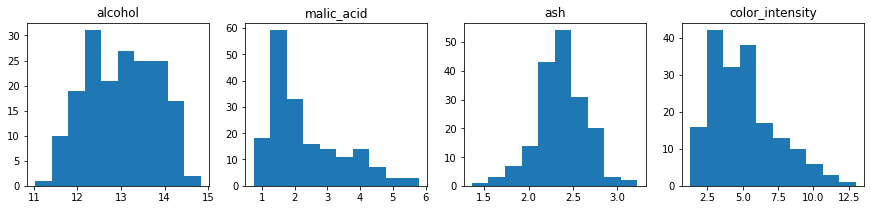

In [9]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(15, 3))

# Iterate over the features, creating a subplot with a histogram for each one.
for idx, feature in enumerate(features):
    plt.subplot(1, 4, idx+1)
    df[feature].hist(bins=10, grid=False)
    plt.title(feature)

#### Step 6.2 Binarize feature values

To make things simple, let's binarize these feature values. That is, we'll treat each measurement as either "low"=0 or "high"=1. I'm just going to choose a threshold for each feature. Threshold = mean value of the feature.

In [10]:
binarize_threshold = []
df_b = df

for feature in features:
    df_b[feature] = np.where(df_b[feature] >= df_b[feature].mean(), 1, 0)
    binarize_threshold.append(df_b[feature].mean())
print('Binarize thresholds:\n', binarize_threshold)
df_b.head()

Binarize thresholds:
 [0.5168539325842697, 0.37640449438202245, 0.48314606741573035, 0.43820224719101125]


,class_label,alcohol,malic_acid,ash,color_intensity
0,0,1,0,1,1
1,0,1,0,0,0
2,0,1,1,1,1
3,0,1,0,1,1
4,0,1,1,1,0


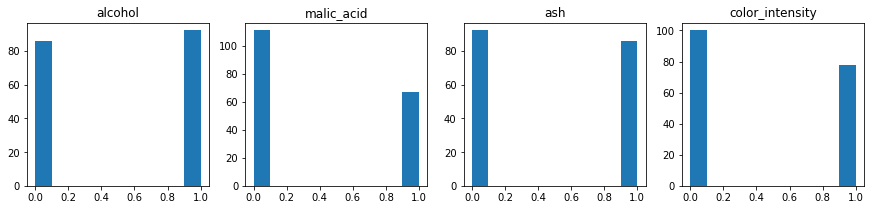

In [11]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(15, 3))

# Iterate over the features, creating a subplot with a histogram for each one.
for idx, feature in enumerate(features):
    plt.subplot(1, 4, idx+1)
    df_b[feature].hist(bins=10, grid=False)
    plt.title(feature)

Let's create a contingency (summary) table for the 'alcohol' feature, and let's see on a piece of paper how the decision tree algo works (see doc <span style="color:chocolate">wine_math_example.pdf</span>).

Note: read info at Step 7 first.

In [12]:
summary_table = pd.DataFrame(df_b.groupby(['class_label', 'alcohol']).agg({'alcohol':['count']}).reset_index())
summary_table.columns=['class_label', 'alcohol', 'count']
summary_table = pd.pivot(summary_table, index = "alcohol", columns = "class_label", values= 'count')
summary_table['total'] = summary_table.loc[:, 0] + summary_table.loc[:, 1] + summary_table.loc[:, 2]
summary_table

class_label,0,1,2,total
alcohol,,,,
0,2,63,21,86
1,57,8,27,92


#### Step 6.3 Split data into train and test sets

In [13]:
# note that I only crate training and test sets (so no validation set) because I do not plan to do hyperparameter tuning.

# create X and y arrays for the non-binerized version and binerized version
X = np.array(df.iloc[:, 1:])
y = np.array(df.iloc[:, 0])

X_b = np.array(df_b.iloc[:, 1:])
y_b = np.array(df_b.iloc[:, 0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=1, stratify=y)

X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.25,
                                                    random_state=1, stratify=y_b)

In [14]:
print('Shape X_b_train: ', X_b_train.shape, '\nShape X_b_test: ', X_b_test.shape,
      '\nShape y_b_train: ', y_b_train.shape, '\nShape y_b_test:', y_b_test.shape)

Shape X_b_train:  (133, 4) 
Shape X_b_test:  (45, 4) 
Shape y_b_train:  (133,) 
Shape y_b_test: (45,)


---
### Step 7: Decission tree classifier
---

Based on the features in the wine dataset, the decission tree algo learns a series of questions to make predictions about class labels. 

The decission tree algo starts at the tree root (contains all data) and splits the data on the feature that results in the largest **Information Gain (IG)**.

Using an iterative process, the algo repeats the splitting procedure at each child node until a leaf node is reached (i.e., when the training examples at each node all belong to the same class).

---

#### Question: How do we decide what are the most informative features (a.k.a., child nodes)? 

---

**Objective**: maximize the **Information Gain (IG)** at each node split:

$IG(D_p,f) = I(D_p) - \sum_{j=1}^{m} \frac{N_j}{N_p} I(D_j)$,

where:
- $D_p$ = dataset of the parent node
- $D_j$ = dataset of the j_th child node
- $f$ = f is the feature to perform the split
- $I$ = our Impurity measure (we will use Entropy)
- $N_p$ = total number of training examples at the parent node
- $N_j$ = total number of training examples at the child j_th node

So the IG is the difference between the impurity of the parent node and the sum of the child node impurities (the lower the impurities of the child nodes, the larger the information gain).

For efficiency, most libraries (incl. scikit-learn) implement binary decission trees, meaning that each parent node is split into two child nodes: <br>
$IG(D_p,f) = I(D_p) - [\frac{N_j}{N_p} I(D_{left}) + \frac{N_j}{N_p} I(D_{right})]$,

We are missing only one thing, the definition of our impurity measure (**entropy**):

$I(t) = -\sum_{i=1}^{c} p(i|t) \times log_2 p(i|t)$

where:
- $p(i|t)$ is the proportion of examples that belong to class $i$ for a particular node, $t$

So the entropy is zero if all example at a node belong to the same class, and it's maximal if we have a uniform distribution (even split between class labels). In other words, entropy is a measure of uncertainty, and it is maximized when the distribution is uniform.

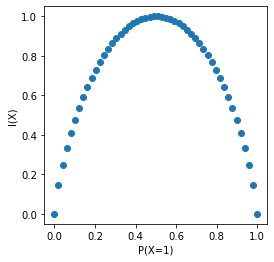

In [15]:
# Show a plot of the entropy, I(X), of a Bernoulli random variable X.
p_values = np.linspace(0, 1, 50)
entropies = [entropy([p, 1-p]) for p in p_values]  #Note: the entropy function is defined at the top
plt.figure(figsize=(4,4))
plt.plot(p_values, entropies, 'o')
plt.xlabel('P(X=1)');
plt.ylabel('I(X)');

#### Step 7.1 Compute the impurity (entropy) of the parent dataset

In other words, we are interested in the entropy of our distribution over labels. You may recall that the distribution in the training data is nearly uniform.

In [16]:
label_probs = get_parent_distribution(y_b_train)
print ('Parent distribution', label_probs)
# Compare the label entropy to a uniform distribution.
print ('Parent entropy:', entropy(label_probs))
print ('Uniform entropy:', entropy([1./3, 1./3, 1./3]))

Parent distribution [0.33082707 0.39849624 0.27067669]
Parent entropy: 1.5672217184800328
Uniform entropy: 1.584962500721156


#### Step 7.1 Compute the impurity of the child nodes

In other words, we want to look at the entropy of each subset of the labels after splitting on each feature. 

Note: no code here because this step is included in the information_gain() function. I will leave it to you to split it in a separate function.

In [17]:
features

['alcohol', 'malic_acid', 'ash', 'color_intensity']

#### Step 7.2 Compute the information gain (IG) for each feature

In [18]:
for feature in range(len(features)):
    IG = information_gain(X_b_train, y_b_train, feature)
    print ('%d %.3f %s' %(feature, IG, features[feature]))

0 0.501 alcohol
1 0.293 malic_acid
2 0.042 ash
3 0.368 color_intensity


According to the information gain metric, alcohol is the most useful feature, followed by color intensity. Let's confirm that this agrees with the sklearn decision tree implementation. Actually, sklearn doesn't expose the information gain values. Instead, it stores the distribution of "feature importances", which reflects the value of each feature in the full decision tree. Let's train a decision tree with max_depth=1 so it will only choose a single feature. Let's also get the test accuracy with this "decision stump".

Using a decision stump -- a tree with depth 1:
Features: ['alcohol', 'malic_acid', 'ash', 'color_intensity']
Feature importances: [0.59825507 0.26302453 0.         0.13872039]
Accuracy: 0.8222222222222222


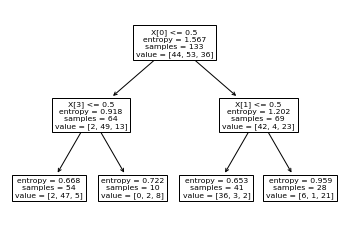

In [19]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(X_b_train, y_b_train)
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(X_b_test, y_b_test))

Question: Are any of the child nodes pure when we use only one feature (max_depth=1)?

---
We've been using the binarized version of the wine features. Recall that we simply chose thresholds for each feature by taking the mean of each feature. Let's use **information gain (IG)** as a metric to choose a best feature and a best threshold.

In [20]:
try_features_and_thresholds(X_train, y_train)

feature best_threshold best_IG feature name
0 0.053 0.501 alcohol
1 0.053 0.293 malic_acid
2 0.053 0.042 ash
3 0.053 0.368 color_intensity


Let's try training actual decision trees (as opposed to stumps) with the original (non-binarized) data. You may need to install GraphViz before exporting the tree.

Accuracy: 0.7777777777777778
Features: ['alcohol', 'malic_acid', 'ash', 'color_intensity']
Feature importances: [0.49734443 0.32480067 0.         0.1778549 ]


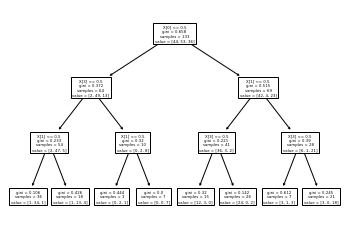

In [21]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='gini', max_depth=3)
clf = dt.fit(X_train, y_train)
print ('Accuracy:', dt.score(X_test, y_test))
tree.plot_tree(clf);

print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
#tree.export_graphviz(clf)

If you successfully output the tree, you should be able to see it here. The first split did not perfectly separate the classes. The next split iwas better at separating classes. At this point, we stop splitting because we don't have enough samples to be convinced that further splitting would generalize well (check what happens if you set the max_depth parameter >2.

Note: a depth 3 tree gets 78% accuracy on the test data. A depth 2 gets 82%! Tree pruning, which is not implemented in sklearn, can be useful for choosing a depth that generalizes well.